# Научная работа. Исследование применения трансформеров для прогнозирования спроса на товары и услуги в нефтедобывающей отрасли

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from functions.feature_selection import FeatureSelection
import pickle
pd.options.mode.chained_assignment = None

## Предсказание спроса на МТР

**Цель**: Построить предиктивную модель спроса на МТР  
**Пилотная группа**: Труба НКТ  
**Используемые данные**:
* Исторические данные потреблений (01/2017 - 08/2023)
* Заказы на трубу НКТ (01/2017 - 12/2024)
* Данные по производственному плану (01/2020 - 12/2024)

### Загрузка данных

In [2]:
# Данные по историческому потреблению 
df_hist = pd.read_csv('Данные/nkt_hist_data.csv')

# Данные по производственному плану
df_prod = pd.read_excel('Данные/nkt_prod_data (DO2).xlsx')

# Заказы на МТР
df_req = pd.read_csv('Данные/nkt_all_requests.csv')

In [3]:
# Обезличить данные
# df_req = df_req.drop(['spp','client_name','business_unit','purchase_request','position_numb'],axis=1)
# df_req.to_csv('Данные/all_requests.csv',index=False)

# df_hist = df_hist.drop(['business_unit','factory','warehouse','spp','for_bu','link','lot'],axis=1)
# df_hist.to_csv('Данные/nkt_hist_data.csv',index=False)

### Используемые переменные

In [101]:
# Используемые в исследовании синтез-группы
analog_groups = ['nkt_60x5_k', 'nkt_73x5p5_k', 'nkt_73x5p5_l','nkt_89x6p5_k']

# Все используемые алгоритмы
algorithms = ['ElasticNet','RandomForestRegressor','XGBRegressor','CatBoostRegressor','Autogluon','Autogluon_timeseries','LSTM']

# Алгоритмы машинного обучения для подбора гиперпараметров через optuna
algorithms_optuna = ['ElasticNet','RandomForestRegressor','XGBRegressor','CatBoostRegressor']

### Предобработка данных

In [5]:
def prepare_prod_data(df):
    """Подготовка датасета с производственными данными"""

    df['feat'] = df['Параметр'] + '_' + df['Имя листа']
    df = df.rename(columns={'Дата':'dt'})
    df = df[~df['dt'].isin([2020,2021,2022,2023,2024,2025])]
    df = df.pivot(index='dt', columns='feat', values='Значение').reset_index()

    return df

In [6]:
df_prod_new = prepare_prod_data(df_prod)

In [7]:
def prepare_date(df, date_column):
    """Подготовка даты к необходимому формату"""
    
    df[date_column] = pd.to_datetime(df[date_column])
    df = df[df[date_column] >= '2017-01-01']
    df['year_and_month'] = df[date_column].apply(lambda x: x.strftime('%Y-%m')) 
    df['year_and_month'] = pd.to_datetime(df['year_and_month'])
    
    return df

In [8]:
df_hist = prepare_date(df = df_hist, date_column = 'posting_date')
df_prod_new = prepare_date(df = df_prod_new, date_column = 'dt')
df_req = prepare_date(df = df_req, date_column = 'need_date')

In [9]:
# Группированные значения заказов МТР
df_req_groupby = df_req.groupby(['analog_group','year_and_month'],as_index=False).agg({'bmu_request':'sum'})

In [10]:
def find_correlation(df, method, threshold):
    """Фунция нахождения наиболее коррелирующих признаков между собой"""

    corr_features = []
    correlation_matrix = df.corr(method = method).abs()

    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            if i != j and correlation_matrix.iloc[i, j] > threshold:
                colname_1 = correlation_matrix.columns[i]
                if colname_1 not in corr_features:
                    corr_features.append(colname_1)

    return corr_features

def prepare_prod_cols(df, method, threshold):
    """Отбор производственных показателей"""

    # Удаление статичных признаков
    not_null_cols = []
    for col in df.columns:
        if df[col].std()!=0:
            not_null_cols.append(col)
    df_update = df[not_null_cols]

    # Удаление коррелирующих признаков
    df_prod_new_for_corr = df_update.drop(['dt','year_and_month'],axis=1)
    corr_features = find_correlation(df_prod_new_for_corr, method, threshold)
    
    df_update = df_update.drop(corr_features, axis=1)

    return df_update

In [11]:
# Параметр threshold - удалять параметры с корреляцией больше данного показателя
# Параметр method - Метод корреляции ('pearson', 'kendall', 'spearman')
df_prod_new = prepare_prod_cols(df_prod_new, method='pearson', threshold=0.9)

In [12]:
def prepare_df_hist(df):
    """Подготовка датасета с историческими данными"""

    df['movement_type'] = df['movement_type'].astype('str')

    # Фильтрация только по расходным операциям
    df = df[df['movement_type'].isin(['221', '291', '941', '991', '953', '601', '943','222', '292', '942', '992', '954', '602', '944'])]

    # Группировка по месяцу и синтез-группе
    df_groupby_month = df.groupby(['analog_group','year_and_month'],as_index=False).agg({'quantity':'sum'})
    df_groupby_month['quantity'] = abs(df_groupby_month['quantity'])
    df_groupby_month['year_and_month'] = pd.to_datetime(df_groupby_month['year_and_month'])

    # Нормировка аномальных значений потреблений, вызванных бухгалтерскими нюансами
    for sg in df_groupby_month['analog_group'].unique():
        df_sg = df_groupby_month[df_groupby_month['analog_group']==sg]
        df_sg_anomal_index = df_sg[df_sg['quantity']>150000].index
        df_groupby_month.loc[df_sg_anomal_index, 'quantity'] = df_sg['quantity'].mean()

    return df_groupby_month

In [13]:
df_hist_groupby = prepare_df_hist(df = df_hist)

In [14]:
# Выбор лучших синтез-групп для обучения
df_hist_groupby = df_hist_groupby[df_hist_groupby['analog_group'].isin(analog_groups)]

### Визуализация целевой переменной

In [15]:
def sg_plots(df):
    """Графики целевой переменной"""
    
    plt.figure(figsize=(14,10))
    sg_unique = df['analog_group'].unique()
    date_range = pd.DataFrame({'year_and_month':pd.date_range(start='2017-01', periods=80, freq=pd.offsets.MonthBegin(1))})

    # Строим графики для каждой синтез-группы
    for i in range(len(sg_unique)):
        df_sg = df[df['analog_group']==sg_unique[i]].drop('analog_group',axis=1)
        df_sg = df_sg.merge(date_range, on='year_and_month', how='right').set_index('year_and_month')
        df_sg['quantity'] = df_sg['quantity'].fillna(0)
        plt.subplot(2,2,i+1)
        plt.title(f'{sg_unique[i]}')
        plt.plot(df_sg["quantity"])

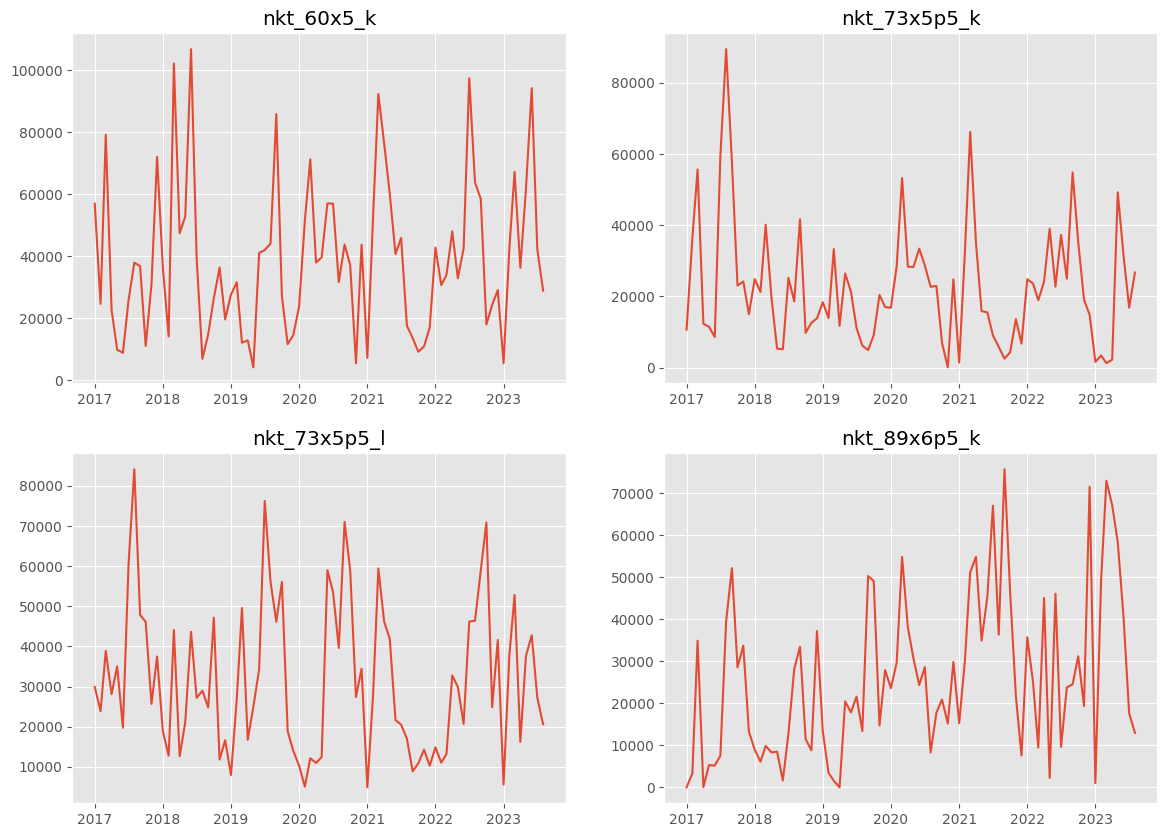

In [16]:
sg_plots(df_hist_groupby)

In [17]:
def merge_df_hist_with_prod_data(df_hist, prod_data, df_req, date_column):
    """Объединение производственных данных с данными потребления"""
    
    df_new = pd.DataFrame()

    # Определяем необходимый временной диапазон
    date_range = pd.DataFrame({'year_and_month':pd.date_range(start='2017-01', periods=80, freq=pd.offsets.MonthBegin(1))})
    
    # Для каждой синтез-группы формируем датафрейм и затем объединяем в один общий
    for sg in df_hist['analog_group'].unique():
        df_hist_sg = df_hist[df_hist['analog_group']==sg]
        df_hist_sg = df_hist_sg.merge(date_range, on='year_and_month', how='right')
        df_hist_sg['analog_group'] = df_hist_sg['analog_group'].fillna(sg)
        df_hist_sg['quantity'] = df_hist_sg['quantity'].fillna(0)

        # Формируем фичи: лаги по данным потребления (назад на 12 месяцев)
        for i in range(1, 13):
            df_hist_sg[f'quantity_{-i}'] = df_hist_sg.groupby('analog_group')['quantity'].transform(lambda x: x.shift(i))

        # Объединяем датафрейм историчксих потреблений для синтез-группы с производственными данными
        df = prod_data.merge(df_hist_sg, how='left',on=date_column)
        df['analog_group'] = df['analog_group'].fillna(sg)
        df = df.fillna(0)

        # Объединяем все отдельные по синтез-группе датафреймы в один
        df_new = pd.concat([df_new, df])
        
    df_new = df_new.merge(df_req, on=['analog_group','year_and_month'], how='left').fillna(0)
    df_new = df_new.drop('year_and_month',axis=1)
        
    return df_new

In [18]:
# Объединенные с производственными данными датасеты
df_full = merge_df_hist_with_prod_data(df_hist_groupby, df_prod_new, df_req_groupby, 'year_and_month')

In [19]:
df_full

,dt,"Ввод доб. скважин из бездействия, шт._Ввод из ДК","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ГРП","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ЗБС","Время простоя доб. скважин, сут_Возвраты","Время работы доб. скважин, сут_Базовая добыча","Выбытие вдз. скважин, скв._ДФ ВДЗ","Выбытие доб. скв. в ППД, шт_Ввод_ННС","Выбытие доб. скв. в ППД, шт_Выбытие ППД","Выбытие доб. скважин в бездействие, скв._Ввод из ДК",...,quantity_-4,quantity_-5,quantity_-6,quantity_-7,quantity_-8,quantity_-9,quantity_-10,quantity_-11,quantity_-12,bmu_request
0,2020-01-01,1.0,1.916667,0.958333,0.0,81909.791656,2.0,0.0,8.0,1.0,...,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,12134.478,31635.935,27650.200,282903.0
1,2020-02-01,0.0,12.666667,7.166667,0.0,78236.583324,3.0,0.0,7.0,0.0,...,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,12134.478,31635.935,0.0
2,2020-03-01,0.0,0.583333,21.083333,0.0,83810.291660,2.0,0.0,16.0,0.0,...,11665.440,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,12134.478,0.0
3,2020-04-01,0.0,5.416667,5.375000,0.0,80798.624989,5.0,0.0,16.0,0.0,...,14615.303,11665.440,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,12905.069,45218.0
4,2020-05-01,0.0,3.375000,0.333333,0.0,71607.916444,2.0,0.0,12.0,0.0,...,23738.386,14615.303,11665.440,27113.139,85883.490,44097.191,42014.674,41120.464,4186.180,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2025-08-01,0.0,8.060000,41.695000,0.0,73798.445000,0.0,0.0,11.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
284,2025-09-01,0.0,7.800000,40.350000,0.0,71388.300000,0.0,1.0,12.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
285,2025-10-01,0.0,8.060000,41.695000,0.0,72684.925000,0.0,2.0,8.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
286,2025-11-01,0.0,7.800000,40.350000,0.0,68081.940000,0.0,1.0,10.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


In [20]:
def get_season(month):
    """Функция, возвращающая время года"""
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3
    
def filter_quantity_cols(col):
    """Выбор признаков без quantity"""

    if 'quantity' in col:
        return False
    else:
        return True

def create_quantity_features(df, is_save):
    """Генерация фичей по производственным данным"""
    
    # Все числовые колонки
    numeric_cols = list(df.select_dtypes(include='float64').columns)
    numeric_cols = filter(filter_quantity_cols, numeric_cols)
    
    # Временные фичи
    df['month'] = df['dt'].dt.month
    df['season'] = df['month'].apply(get_season)
    
    # Фичи с лагами за 12 месяцев назад по всем колонкам
    for col in numeric_cols:
        for i in range(1, 13):
            df[f'{col}_{-i}'] = df.groupby('analog_group')[col].transform(lambda x: x.shift(i))

    # Параметр синтез-группы в начало Датафрейма
    sg_col = df['analog_group']
    df = df.drop('analog_group',axis=1)
    df.insert (0, 'analog_group', sg_col)

    # Сохранение датасета
    if is_save==True:
        with open(f'datasets/df_final.pkl', 'wb') as f: pickle.dump(df, f)
        
    return df

In [21]:
df_final = create_quantity_features(df_full, is_save=False)

In [22]:
# Обрезаем по необходимой дате
df_final_after_2020 = df_final[(df_final['dt']>='2020.01.01') & (df_final['dt']<='2024.12.01')].fillna(0)

In [23]:
df_final_after_2020

,analog_group,dt,"Ввод доб. скважин из бездействия, шт._Ввод из ДК","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ГРП","Время простоя доб. скважин (из б/д, новые, от нуля), сут_ЗБС","Время простоя доб. скважин, сут_Возвраты","Время работы доб. скважин, сут_Базовая добыча","Выбытие вдз. скважин, скв._ДФ ВДЗ","Выбытие доб. скв. в ППД, шт_Ввод_ННС","Выбытие доб. скв. в ППД, шт_Выбытие ППД",...,bmu_request_-3,bmu_request_-4,bmu_request_-5,bmu_request_-6,bmu_request_-7,bmu_request_-8,bmu_request_-9,bmu_request_-10,bmu_request_-11,bmu_request_-12
0,nkt_60x5_k,2020-01-01,1.0,1.916667,0.958333,0.0,81909.791656,2.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
1,nkt_60x5_k,2020-02-01,0.0,12.666667,7.166667,0.0,78236.583324,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
2,nkt_60x5_k,2020-03-01,0.0,0.583333,21.083333,0.0,83810.291660,2.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
3,nkt_60x5_k,2020-04-01,0.0,5.416667,5.375000,0.0,80798.624989,5.0,0.0,16.0,...,282903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
4,nkt_60x5_k,2020-05-01,0.0,3.375000,0.333333,0.0,71607.916444,2.0,0.0,12.0,...,0.0,282903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,nkt_89x6p5_k,2024-08-01,0.0,8.060000,41.695000,0.0,74271.691000,0.0,3.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25516.116,0.000
272,nkt_89x6p5_k,2024-09-01,0.0,7.800000,40.350000,0.0,71831.280000,0.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,25516.116
273,nkt_89x6p5_k,2024-10-01,0.0,8.060000,41.695000,0.0,73127.822000,0.0,2.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000
274,nkt_89x6p5_k,2024-11-01,0.0,7.800000,40.350000,0.0,68467.886000,0.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000


### Отбор признаков

In [78]:
def func_feature_selection(df, method, features_number, is_save):
    """Выбор лучших фичей для каждой синтез-группы"""

    best_features_dict = {}
    
    # Для каждой синтез-группы свои фичи
    for sg in df['analog_group'].unique():
        df_sg = df[df['analog_group']==sg]

        X_ = df_sg.loc[:, ~df_sg.columns.str.startswith('quantity')].drop(columns=['analog_group']).set_index('dt')
        y_ = df_sg.loc[:, 'quantity']
        
        best_features = FeatureSelection(method=method).filter_X(X=X_,y=y_, n_features=features_number).columns.tolist()
        best_features_dict[sg] = best_features
    
    # Сохранение фичей
    if is_save == True:
        with open(f'features/features_{method}_{features_number}.pkl', 'wb') as f: pickle.dump(best_features_dict, f)

    return best_features_dict

In [83]:
# Параметр method - Метод отбора параметров (catboost, pearson,rf_lasso)
best_features = func_feature_selection(df_final_after_2020, method='catboost', features_number=40, is_save=True)

[Feature Selection] catboost completed. Out shape = (60, 40). Total time = 6.94s
[Feature Selection] catboost completed. Out shape = (60, 40). Total time = 6.82s
[Feature Selection] catboost completed. Out shape = (60, 40). Total time = 6.72s
[Feature Selection] catboost completed. Out shape = (60, 40). Total time = 6.74s


### Обучение

Baseline:
* CatBoost
* Рекурентные нейросети
* AutoML

#### Подготовка даных для обучения

In [26]:
# Импорт основных библиотек для обучения
from catboost import CatBoostRegressor
import optuna
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [114]:
def train_test_split_dataset(df, analog_groups, scaler, features_name, is_save):
    """Разделение датасета на обучающую и тестовую выборку"""

    # Загрузка лучших фичей
    with open(f'features/{features_name}.pkl', 'rb') as f: best_features = pickle.load(f)
    
    # Для каждой синтез-группы свой датасет
    for analog_group in analog_groups:
        df_sg = df[df['analog_group']==analog_group]

        # Лучшие фичи для синтез-группы
        best_features_sg = best_features[analog_group]
        best_features_sg.append('dt')

        # Выделение таргета и предикторов
        x = df_sg[best_features_sg]
        y = df_sg[['analog_group','quantity','dt']]

        # Нормализация данных 
        if scaler == 'MinMax':
          scaler = MinMaxScaler()
        elif scaler == 'Standart':
          scaler = StandardScaler()

        x[x.select_dtypes(include='number').columns] = scaler.fit_transform(x[x.select_dtypes(include='number').columns])

        # Обучающая выборка
        x_train = x[(x['dt']>='2020-01-01')&(x['dt']<='2022-08-01')].set_index('dt')
        y_train = y[(y['dt']>='2020-01-01')&(y['dt']<='2022-08-01')].drop(['analog_group'],axis=1).set_index('dt')

        # Тестовая выборка
        x_test = x[(x['dt']>='2022-09-01')&(x['dt']<='2023-08-01')].set_index('dt')
        y_test = y[(y['dt']>='2022-09-01')&(y['dt']<='2023-08-01')].set_index('dt')

        # Сохраняем датасеты
        if is_save == True:
           with open(f'datasets/x_train_{analog_group}.pkl', 'wb') as f: pickle.dump(x_train, f)
           with open(f'datasets/y_train_{analog_group}.pkl', 'wb') as f: pickle.dump(y_train, f)
           with open(f'datasets/x_test_{analog_group}.pkl', 'wb') as f: pickle.dump(x_test, f)
           with open(f'datasets/y_test_{analog_group}.pkl', 'wb') as f: pickle.dump(y_test, f)

In [115]:
# Параметр scaler - нормализация признаков (MinMax, Standart)
train_test_split_dataset(df_final_after_2020, analog_groups, scaler='MinMax', features_name='features_catboost_40', is_save=True)

#### Optuna подбор гиперпараметров

In [90]:
def create_objective(algorithm, analog_group):
  """Функция для передачи параметра algorithm в optuna_optimize"""

  def optuna_optimize(trial):
    """Функция оптизации optuna"""

    if algorithm == 'ElasticNet':
      model = linear_model.ElasticNet(
          alpha = trial.suggest_float("alpha", 0.0001, 10),
          random_state = 33
      )
    elif algorithm == 'RandomForestRegressor':
      model = RandomForestRegressor(
          n_estimators = trial.suggest_int('n_estimators', 100, 1000, 10),
          min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 9, 1),
          max_depth = trial.suggest_int('max_depth', 1, 30, 1),
          criterion = trial.suggest_categorical('criterion',['squared_error', 'absolute_error', 'friedman_mse', 'poisson']),
          random_state=33,
          n_jobs=-1
      )
    elif algorithm == 'XGBRegressor':
      model = XGBRegressor(
          min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
          gamma=trial.suggest_float("gamma", 0.5, 5),
          subsample=trial.suggest_float("subsample", 0.6, 1),
          colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1),
          max_depth=trial.suggest_int("max_depth", 3, 15),
          n_estimators=trial.suggest_int("n_estimators", 10, 2000),
          learning_rate=trial.suggest_float("learning_rate", 0.01, 1)
      )
    elif algorithm == 'CatBoostRegressor':
      model = CatBoostRegressor(
          iterations = trial.suggest_int('iterations', 100, 1500),
          learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1),
          depth = trial.suggest_int('depth', 3, 12),
          l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 100),
          # cat_features=['analog_group'],
          verbose=False
      )

    # Загрузка выборок для синтез-группы
    with open(f'datasets/x_train_{analog_group}.pkl', 'rb') as f: x_train = pickle.load(f)
    with open(f'datasets/y_train_{analog_group}.pkl', 'rb') as f: y_train = pickle.load(f)
    with open(f'datasets/x_test_{analog_group}.pkl', 'rb') as f: x_test = pickle.load(f)
    with open(f'datasets/y_test_{analog_group}.pkl', 'rb') as f: y_test = pickle.load(f)

    # Обучение модели
    model.fit(x_train, y_train)
      
    # Вычисление метрики для оптимизации
    y_pred = model.predict(x_test)
    rmse = mean_squared_error(y_test['quantity'], y_pred, squared=False)
    return rmse
  
  return optuna_optimize

In [91]:
def train_optuna(algorithms, analog_groups, n_trials, is_save):
    """Подбор гиперпараметров через optuna"""

    # Подбор гиперпараметров для каждой синтез-группы и модели
    for analog_group in analog_groups:
        for algorithm_name in algorithms:
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(direction="minimize")
            study.optimize(create_objective(algorithm_name, analog_group), n_trials=n_trials, n_jobs=-1)

            # Сохранение параметров
            if is_save == True:
                with open(f'params/{analog_group}_{algorithm_name}_params.pkl', 'wb') as f: pickle.dump(study.best_params, f)

In [93]:
%%time

# Подбор гиперпараметров через optuna
train_optuna(algorithms_optuna, analog_groups, n_trials=50, is_save=True)

CPU times: total: 51min 26s
Wall time: 7min 58s


#### Обучение моделей

In [94]:
def train_models(analog_group, algorithm_name, random_state, is_save):
    """Обучение моделей"""

    # Загрузка подобранных гиперпараметров
    with open(f'params/{analog_group}_{algorithm_name}_params.pkl', 'rb') as f: params = pickle.load(f)

    # Загрузка датасетов обучающей выборки
    with open(f'datasets/x_train_{analog_group}.pkl', 'rb') as f: x_train = pickle.load(f)
    with open(f'datasets/y_train_{analog_group}.pkl', 'rb') as f: y_train = pickle.load(f)

    if algorithm_name == 'ElasticNet':
        model = linear_model.ElasticNet(**params,random_state=random_state)
    elif algorithm_name == 'RandomForestRegressor':
        model = RandomForestRegressor(**params,random_state=random_state)
    elif algorithm_name == 'XGBRegressor':
        model = XGBRegressor(**params,random_state=random_state)
    elif algorithm_name == 'CatBoostRegressor':
        model = CatBoostRegressor(**params,random_state=random_state, verbose=False)
    
    # Обучение моделей
    model.fit(x_train, y_train)

    # Сохранение моделей
    if is_save == True:
        with open(f'models/{analog_group}_{algorithm_name}_model.pkl', 'wb') as f: pickle.dump(model, f)

In [95]:
# Обучение моделей
for analog_group in analog_groups:
    for algorithm_name in algorithms_optuna:
        train_models(analog_group, algorithm_name, random_state=42, is_save = True)

##### AutoML

In [54]:
def automl_train(analog_groups, presets, is_save):
    """Обучение модели АвтоМЛ Autogluon"""

    for analog_group in analog_groups:
        
        # Загрузка тренировочных выборок для синтез-группы
        with open(f'datasets/x_train_{analog_group}.pkl', 'rb') as f: x_train = pickle.load(f)
        with open(f'datasets/y_train_{analog_group}.pkl', 'rb') as f: y_train = pickle.load(f)
        df_sg = pd.concat([x_train, y_train], axis=1)

        # АвтоМЛ для задачи регрессии
        df_sg_tabular = TabularDataset(df_sg)
        autogluon = TabularPredictor(label='quantity')
        pipeline = autogluon.fit(df_sg_tabular, presets=presets, verbosity = 0)
    
        # Сохранение моделей
        if is_save == True:
            with open(f'models/{analog_group}_Autogluon_model.pkl', 'wb') as f: pickle.dump(pipeline, f)

In [55]:
%%time

# Параметр presets - Дополнительные предустановленные конфигурации обучения (fast_training, medium_quality, high_quality, best_quality)
automl_train(analog_groups, presets='best_quality', is_save = True)

No path specified. Models will be saved in: "AutogluonModels\ag-20231015_094105\"
No path specified. Models will be saved in: "AutogluonModels\ag-20231015_094135\"
No path specified. Models will be saved in: "AutogluonModels\ag-20231015_094202\"
No path specified. Models will be saved in: "AutogluonModels\ag-20231015_094223\"


CPU times: total: 9.89 s
Wall time: 1min 40s


In [48]:
def automl_timeseries_train(analog_groups, presets, is_save):
    """Обучение модели АвтоМЛ Autogluon для временного ряда"""

    for analog_group in analog_groups:

        # Загрузка обучающей выборки
        with open(f'datasets/x_train_{analog_group}.pkl', 'rb') as f: x_train = pickle.load(f)
        with open(f'datasets/y_train_{analog_group}.pkl', 'rb') as f: y_train = pickle.load(f)
        df_sg = pd.concat([x_train, y_train], axis=1)

        # АвтоМЛ для временного ряда
        df_sg['item_id'] = 0
        df_sg = df_sg.reset_index()
        df_sg = df_sg.rename(columns={'dt':'timestamp'})

        # Построение предсказания
        df_sg_time_series = TimeSeriesDataFrame(df_sg)
        pipeline_timeseries = TimeSeriesPredictor(target='quantity', prediction_length=12).fit(df_sg_time_series, presets=presets, verbosity = 0)
        predictions = pipeline_timeseries.predict(df_sg_time_series)

        # Подготовка датасета с предсказаниями
        predictions = predictions.rename(columns={'mean':'predict_test'})
        predictions = predictions.reset_index().set_index('timestamp')[['predict_test']]
        predictions['analog_group'] = analog_group
        predictions['model'] = 'Autogluon_timeseries'
    
        # Сохранение предсказание
        if is_save == True:
            with open(f'datasets/{analog_group}_Autogluon_timeseries_predicts.pkl', 'wb') as f: pickle.dump(predictions, f)

In [49]:
%%time

# Параметр presets - Дополнительные предустановленные конфигурации обучения (fast_training, medium_quality, high_quality, best_quality)
automl_timeseries_train(analog_groups, presets='best_quality', is_save=True)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': None,
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': {'num_trials': 3,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_val_windows': 1,
 'prediction_length': 12,
 'random_seed': None,
 'target': 'quantity',
 'time_limit': None,
 'verbosity': 0}
Provided training data set with 32 rows, 1 items (item = single time series). Average time series length is 32.0. Data frequency is 'MS'.


  0%|          | 0/3 [00:00<?, ?it/s]

	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
Global seed set to 123
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': None,
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': {'num_trials': 3,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_val_windows': 1,
 'prediction_length': 12,
 'random_seed': None,
 'target': 'quantity',
 'time_limit': None,
 

  0%|          | 0/3 [00:00<?, ?it/s]

	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
Global seed set to 123
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': None,
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': {'num_trials': 3,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_val_windows': 1,
 'prediction_length': 12,
 'random_seed': None,
 'target': 'quantity',
 'time_limit': None,
 

  0%|          | 0/3 [00:00<?, ?it/s]

	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
Global seed set to 123
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': None,
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': {'num_trials': 3,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_val_windows': 1,
 'prediction_length': 12,
 'random_seed': None,
 'target': 'quantity',
 'time_limit': None,
 

  0%|          | 0/3 [00:00<?, ?it/s]

	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.
Global seed set to 123


CPU times: total: 1min 8s
Wall time: 4min 37s


##### LSTM

In [106]:
# Таргеты
target_cols = [
    'quantity_1',
    'quantity_2',
    'quantity_3',
    'quantity_4',
    'quantity_5',
    'quantity_6',
    'quantity_7',
    'quantity_8',
    'quantity_9',
    'quantity_10',
    'quantity_11',
    'quantity_12'
]

def train_LSTM(df, target_cols, is_save_datasets, is_save_predicts):
    """Обучение LSTM"""

    # Подготовка датасета
    date_range = pd.DataFrame({'year_and_month':pd.date_range(start='2017-01', periods=80, freq=pd.offsets.MonthBegin(1))})
    df_new = pd.DataFrame()

    # Для каждой синтез-группы добавляем пропущенные значения временного ряда в датасет
    for sg in df['analog_group'].unique():
        df_sg = df[df['analog_group']==sg]
        df_sg = df_sg.merge(date_range, on='year_and_month', how='right')
        df_sg['analog_group'] = df_sg['analog_group'].fillna(sg)
        df_sg['quantity'] = df_sg['quantity'].fillna(0)
        df_new = pd.concat([df_new, df_sg])
    
    df_new = df_new.set_index('year_and_month')

    # Формируем фичи лагов потребления (Вперед и назад на 12 месяцев)
    for i in range(1, 13):
        df_new[f'quantity_{-i}'] = df_new.groupby('analog_group')['quantity'].transform(lambda x: x.shift(i))
    for i in range(-1, -13, -1):
        df_new[f'quantity_{-i}'] = df_new.groupby('analog_group')['quantity'].transform(lambda x: x.shift(i))

    # # Сохранение временных датасетов
    # if is_save_datasets == True:
    #     with open(f'datasets/x_train_timeseries.pkl', 'wb') as f: pickle.dump(x_train, f)
    #     with open(f'datasets/y_train_timeseries.pkl', 'wb') as f: pickle.dump(y_train, f)
    #     with open(f'datasets/x_test_timeseries.pkl', 'wb') as f: pickle.dump(x_test, f)

    for analog_group in df_new['analog_group'].unique():

        df_new_sg = df_new[df_new['analog_group']==analog_group].drop('analog_group',axis=1)
        
        x = df_new_sg.drop(target_cols, axis=1)
        y = df_new_sg[target_cols]

        # Нормализация данных
        scaler_x = MinMaxScaler(feature_range=(0, 1))
        x_scaled = scaler_x.fit_transform(x.values)
        x = pd.DataFrame(x_scaled, index=x.index, columns=x.columns)

        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler_y.fit_transform(y.values)
        y = pd.DataFrame(y_scaled, index=y.index, columns=y.columns)

        # Разделение на тренироввочную и тестовую выборку
        x_train_sg = x.loc['2018-01-01':'2021-07-01']
        x_test_sg = x.loc['2022-08-01'].to_frame().T

        y_train_sg = y.loc['2018-01-01':'2021-07-01']

        # Приведение всех выборок к необходимому для обучения формату
        x_train_np = np.array(x_train_sg)
        x_train_new = np.reshape(x_train_np, (x_train_np.shape[0],x_train_np.shape[1],1))

        x_test_np = np.array(x_test_sg)
        x_test_new = np.reshape(x_test_np, (x_test_np.shape[0],x_test_np.shape[1],1))

        y_train_new = np.reshape(y_train_sg, (y_train_sg.shape[0], 12))

        # Обучение LSTM
        tf.random.set_seed(7)
        model = Sequential()
        model.add(LSTM(units=12, return_sequences=True, input_shape=(x_train_sg.shape[1],1)))
        model.add(LSTM(units=12))
        model.add(Dense(12))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(x_train_new, y_train_new, epochs=150, batch_size=1, verbose=2)

        # Предсказание модели LSTM
        testPredict = model.predict(x_test_new)

        # Обратное преобразование нормализации
        testPredict = scaler_y.inverse_transform(testPredict)

        # Подготовка датасета с предсказаниями для последующего сохранения
        df_test_predict_sg = pd.DataFrame({'analog_group':analog_group,'predict_test':testPredict[0]})

        # Сохранение предсказаний
        if is_save_predicts == True:
            with open(f'datasets/{analog_group}_LSTM_test_predicts.pkl', 'wb') as f: pickle.dump(df_test_predict_sg, f)

In [107]:
train_LSTM(df_hist_groupby, target_cols, is_save_datasets=True, is_save_predicts=True)

Epoch 1/150
43/43 - 2s - loss: 0.1119 - 2s/epoch - 39ms/step
Epoch 2/150
43/43 - 0s - loss: 0.0659 - 125ms/epoch - 3ms/step
Epoch 3/150
43/43 - 0s - loss: 0.0550 - 125ms/epoch - 3ms/step
Epoch 4/150
43/43 - 0s - loss: 0.0530 - 124ms/epoch - 3ms/step
Epoch 5/150
43/43 - 0s - loss: 0.0522 - 123ms/epoch - 3ms/step
Epoch 6/150
43/43 - 0s - loss: 0.0520 - 123ms/epoch - 3ms/step
Epoch 7/150
43/43 - 0s - loss: 0.0517 - 124ms/epoch - 3ms/step
Epoch 8/150
43/43 - 0s - loss: 0.0517 - 124ms/epoch - 3ms/step
Epoch 9/150
43/43 - 0s - loss: 0.0516 - 122ms/epoch - 3ms/step
Epoch 10/150
43/43 - 0s - loss: 0.0515 - 122ms/epoch - 3ms/step
Epoch 11/150
43/43 - 0s - loss: 0.0514 - 122ms/epoch - 3ms/step
Epoch 12/150
43/43 - 0s - loss: 0.0515 - 121ms/epoch - 3ms/step
Epoch 13/150
43/43 - 0s - loss: 0.0510 - 123ms/epoch - 3ms/step
Epoch 14/150
43/43 - 0s - loss: 0.0507 - 120ms/epoch - 3ms/step
Epoch 15/150
43/43 - 0s - loss: 0.0505 - 121ms/epoch - 3ms/step
Epoch 16/150
43/43 - 0s - loss: 0.0503 - 124ms/epoc

#### Формирование предсказаний

In [123]:
def create_predict_tables(analog_groups, algorithms):
    """Создание таблиц предсказаний"""

    y_train_final = pd.DataFrame()
    y_test_final = pd.DataFrame()

    for analog_group in analog_groups:
        for algorithm_name in algorithms:

            # Загрузка данных
            with open(f'datasets/x_train_{analog_group}.pkl', 'rb') as f: x_train = pickle.load(f)
            with open(f'datasets/x_test_{analog_group}.pkl', 'rb') as f: x_test = pickle.load(f)
            with open(f'datasets/y_train_{analog_group}.pkl', 'rb') as f: y_train = pickle.load(f)
            with open(f'datasets/y_test_{analog_group}.pkl', 'rb') as f: y_test = pickle.load(f)
            
            if algorithm_name == 'Autogluon_timeseries':
                with open(f'datasets/{analog_group}_Autogluon_timeseries_predicts.pkl', 'rb') as f: autogluon_timeseries_predicts = pickle.load(f)
            elif algorithm_name == 'LSTM':
                with open(f'datasets/{analog_group}_LSTM_test_predicts.pkl', 'rb') as f: LSTM_predicts = pickle.load(f)
            else:
                with open(f'models/{analog_group}_{algorithm_name}_model.pkl', 'rb') as f: model = pickle.load(f)

            y_train_table = y_train
            y_test_table = y_test
            
            # Предсказания на трейне и тесте 
            if algorithm_name == 'Autogluon':
                y_train_predict = model.predict(x_train, as_pandas=False)
                y_test_predict = model.predict(x_test, as_pandas=False)
            elif algorithm_name == 'Autogluon_timeseries':
                y_train_predict = np.nan
                y_test_predict = autogluon_timeseries_predicts['predict_test']
            elif algorithm_name == 'LSTM':
                y_train_predict = np.nan
                y_test_predict = LSTM_predicts['predict_test']
            else:
                y_train_predict = model.predict(x_train)
                y_test_predict = model.predict(x_test)
                
            # Датафрейм теста
            y_test_table['predict_test'] = np.array(y_test_predict)
            y_test_table['model'] = algorithm_name
            y_test_table.loc[y_test_table['predict_test'] < 0,'predict_test'] *= 0

            # Датафрейм трейна
            # y_train_table = y_train_table[(y_train_table['dt']<'2022.09.01') & (y_train_table['dt']>='2020.01.01')][['analog_group','quantity','dt']].set_index('dt')
            y_train_table['predict_train'] = y_train_predict
            y_train_table['analog_group'] = analog_group
            y_train_table['model'] = algorithm_name
            y_train_table.loc[y_train_table['predict_train'] < 0,'predict_train'] *= 0

            # Объединение датафреймов
            y_train_final = pd.concat([y_train_final, y_train_table])
            y_test_final = pd.concat([y_test_final, y_test_table])

    return y_train_final, y_test_final

In [124]:
y_train_table, y_test_table = create_predict_tables(analog_groups, algorithms)

In [125]:
y_test_table

,analog_group,quantity,predict_test,model
dt,,,,
2022-09-01,nkt_60x5_k,58486.037,39749.135628,ElasticNet
2022-10-01,nkt_60x5_k,18025.465,33344.252214,ElasticNet
2022-11-01,nkt_60x5_k,24327.850,30285.492859,ElasticNet
2022-12-01,nkt_60x5_k,29128.640,32828.672595,ElasticNet
2023-01-01,nkt_60x5_k,5515.215,34065.735994,ElasticNet
...,...,...,...,...
2023-04-01,nkt_89x6p5_k,67237.090,46816.472656,LSTM
2023-05-01,nkt_89x6p5_k,58409.550,41167.917969,LSTM
2023-06-01,nkt_89x6p5_k,40505.690,37810.746094,LSTM


#### Визуализация результатов

In [163]:
def results_plot(y_train_table, y_test_table, model_name, save_fig):
    """Визуализация результатов"""

    plt.figure(figsize=(20,12))

    # Фильтруем датасет по выбранной модели
    sg_unique = y_test_table['analog_group'].unique()
    y_train_table_model = y_train_table[y_train_table['model']==model_name]
    y_test_table_model = y_test_table[y_test_table['model']==model_name]

    # Строим графики для каждой синтез-группы
    for i in range(len(sg_unique)):
        y_train_table_sg = y_train_table_model[y_train_table_model['analog_group']==sg_unique[i]]
        y_test_table_sg = y_test_table_model[y_test_table_model['analog_group']==sg_unique[i]]
            
        plt.subplot(2,2,i+1)
        plt.title(f'{sg_unique[i]}_{model_name}')
        plt.plot(y_train_table_sg['quantity'], linewidth=3, color='#686963', label='True (training)')
        plt.plot(y_train_table_sg['predict_train'], linewidth=3, color="#DB5461", label='Predict (training)')
        plt.axvline(y_train_table_sg.index[-1], color ='blue', lw = 3, alpha = 0.9, label='Test')
        plt.plot(y_test_table_sg['quantity'], linewidth=3, color='#686963', label='True (holdout)')
        plt.plot(y_test_table_sg['predict_test'], linewidth=3, color="#DB5461", label='Prediction (holdout)')
        plt.legend(loc=2, facecolor='white', framealpha=1, fontsize='small')

    # Сохраняем график
    if save_fig == True:
        plt.savefig(f'plots/{sg_unique[i]}_{model_name}.png', facecolor='white', dpi=200)

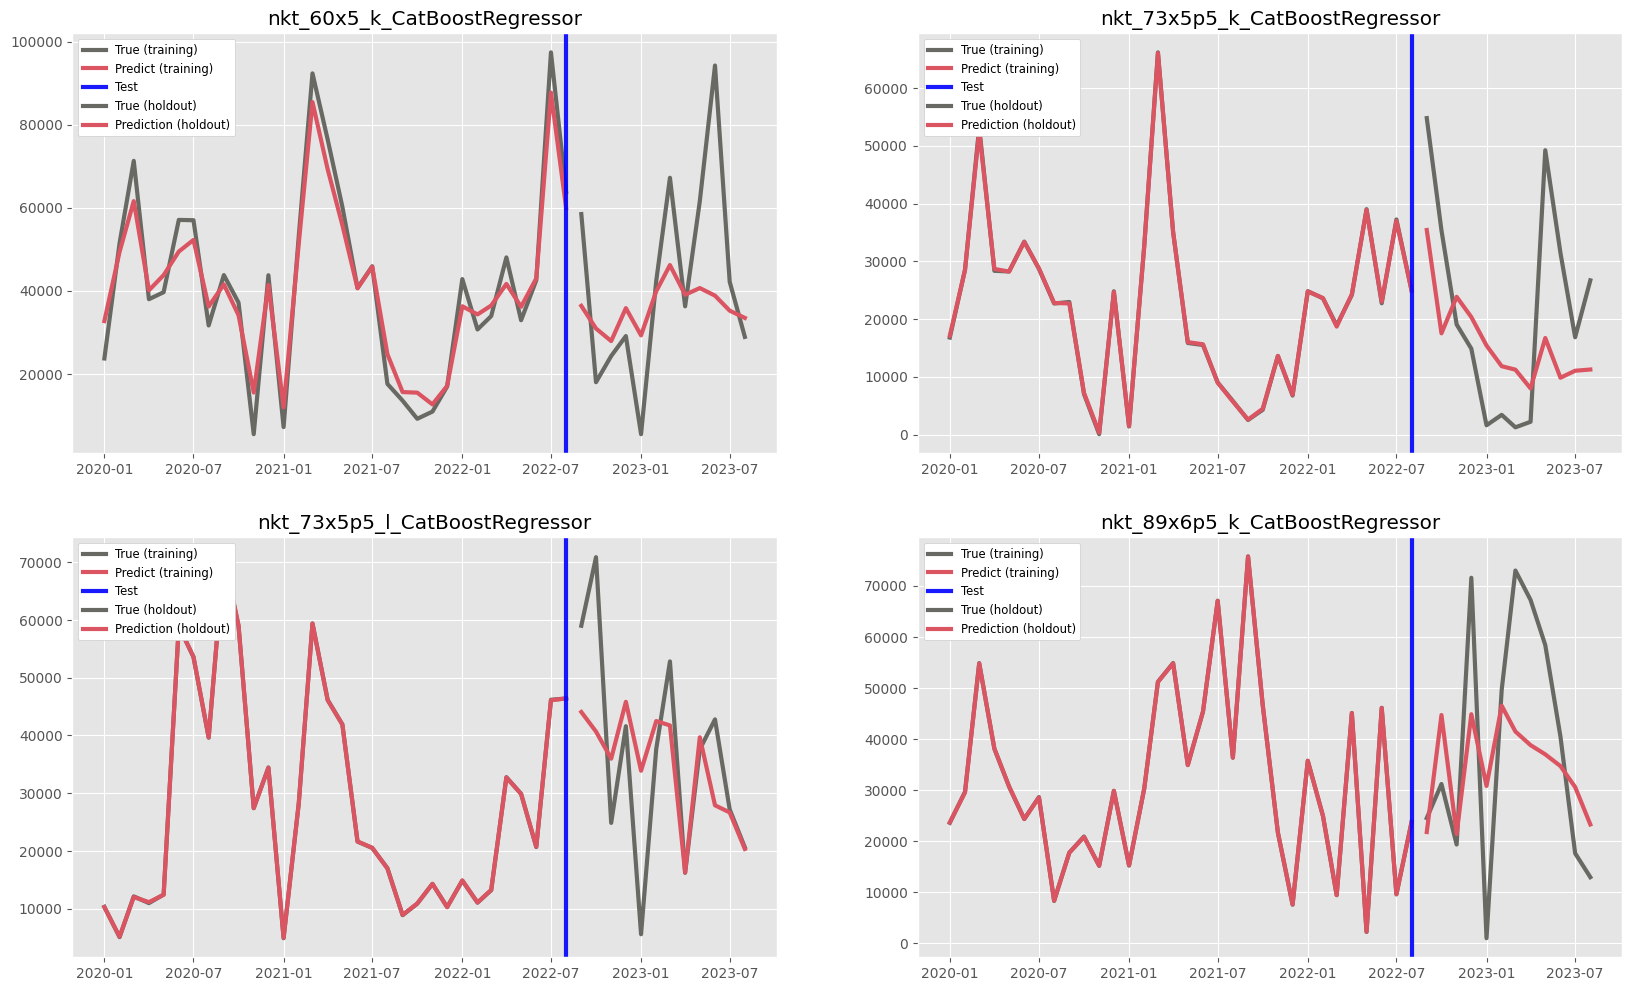

In [164]:
results_plot(y_train_table, y_test_table, 'CatBoostRegressor', save_fig = True)

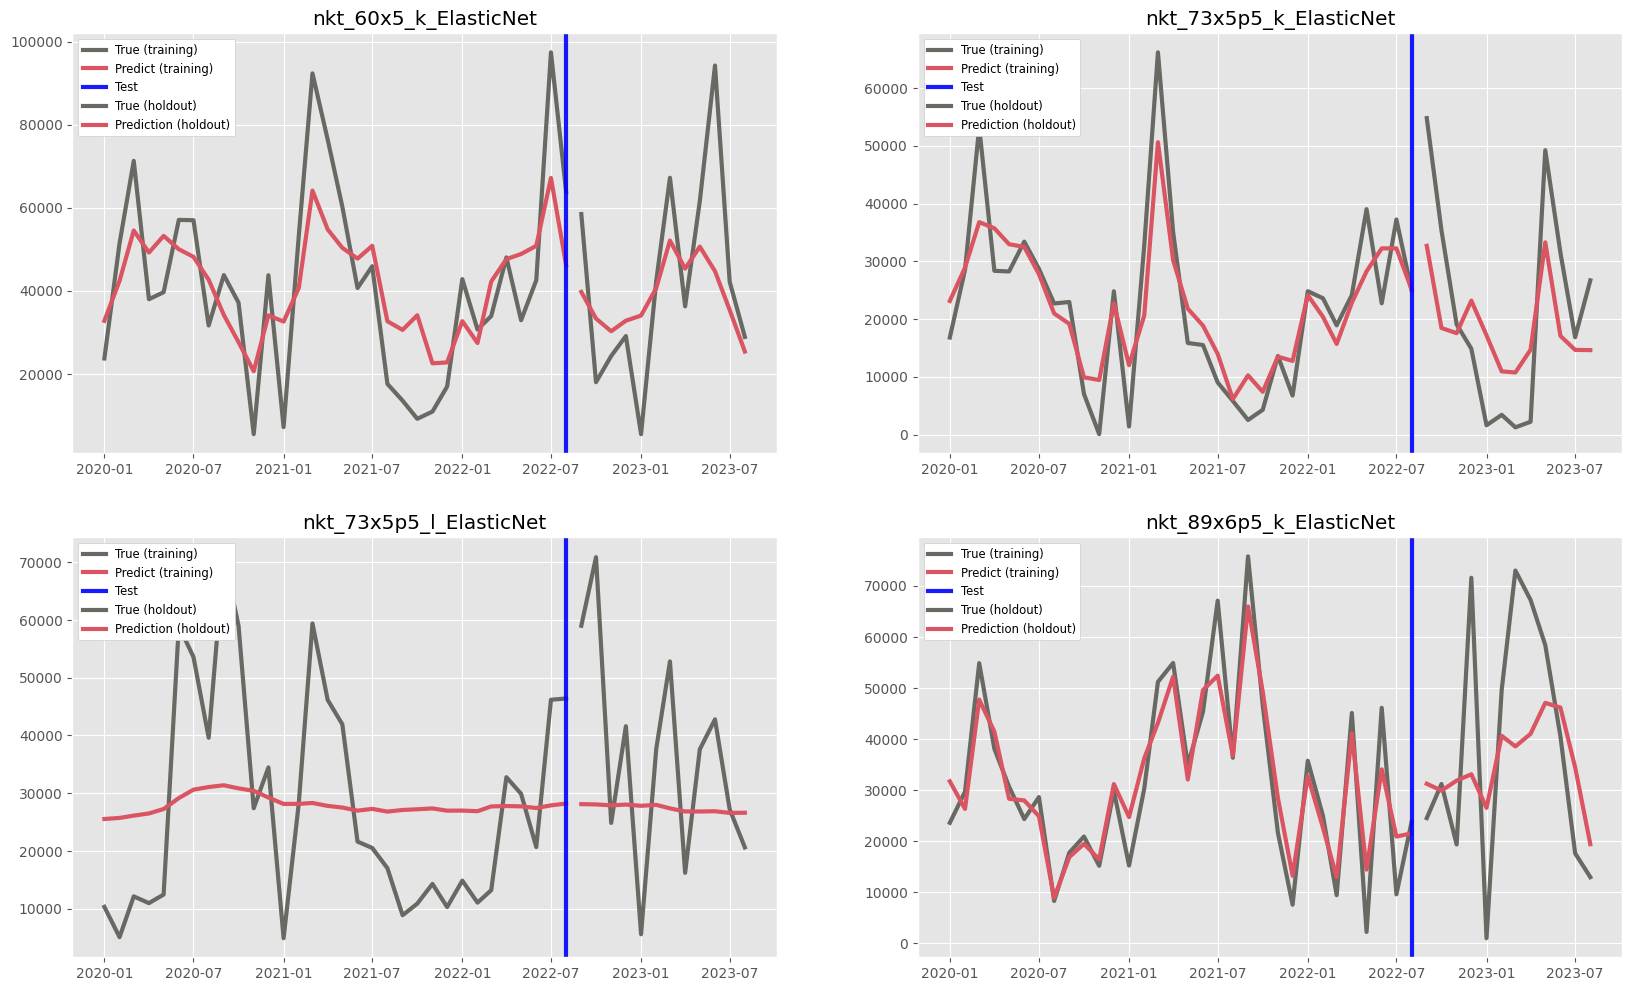

In [165]:
results_plot(y_train_table, y_test_table, 'ElasticNet', save_fig = True)

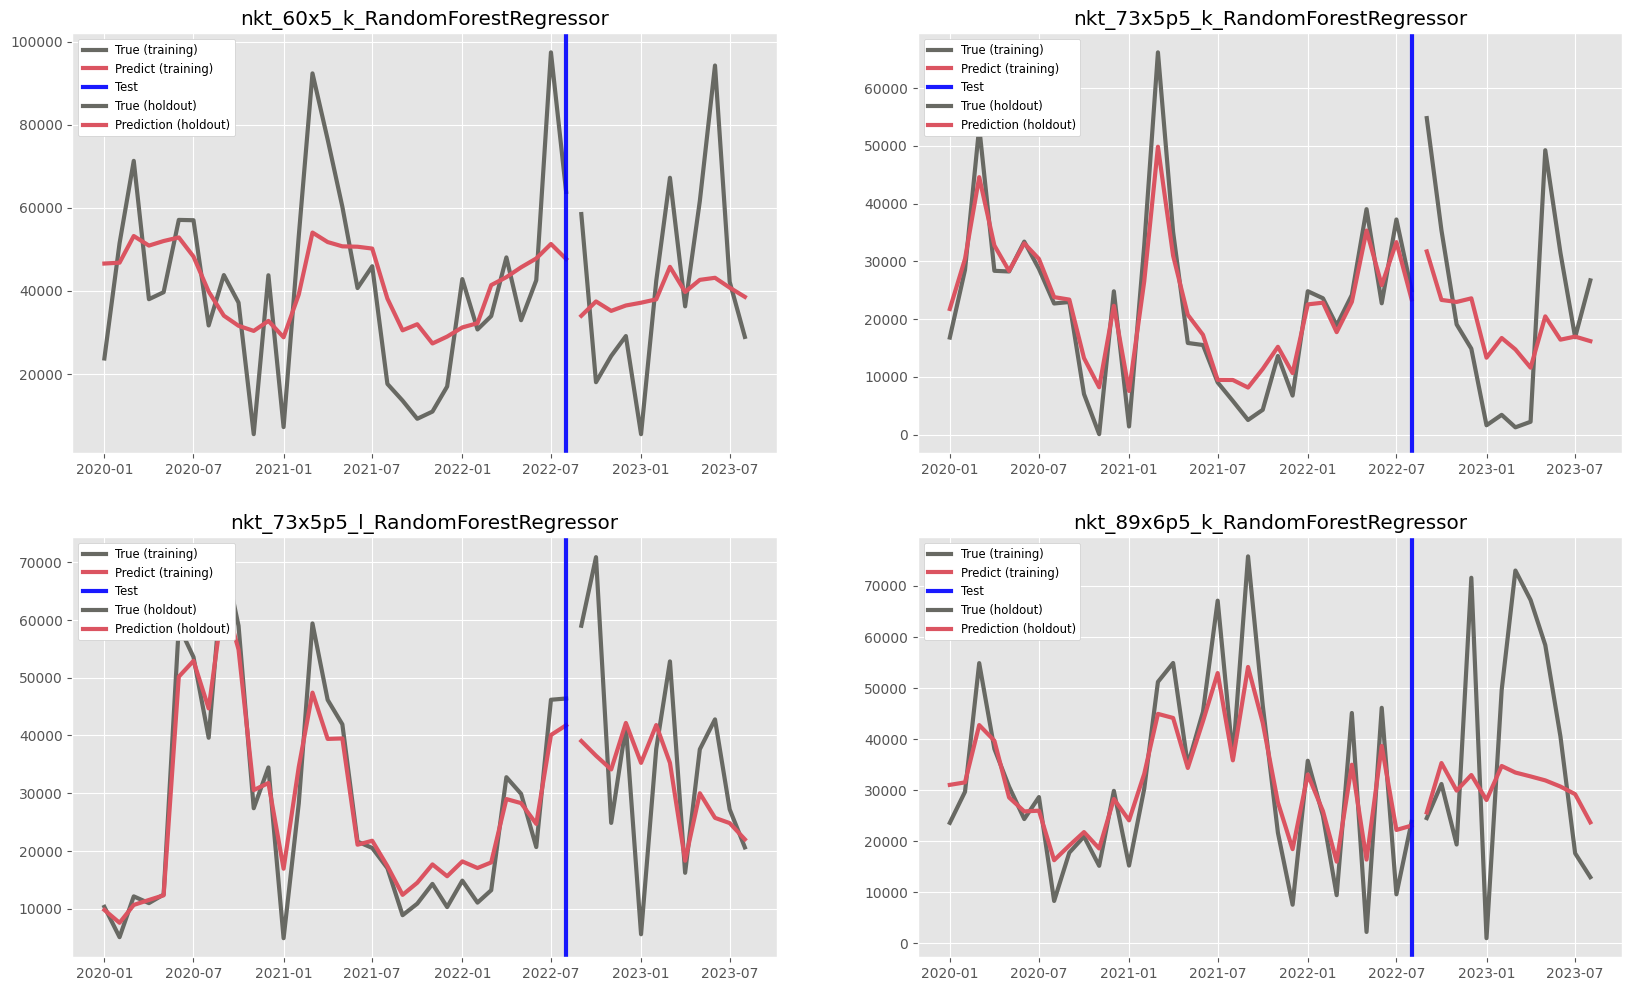

In [166]:
results_plot(y_train_table, y_test_table, 'RandomForestRegressor', save_fig = True)

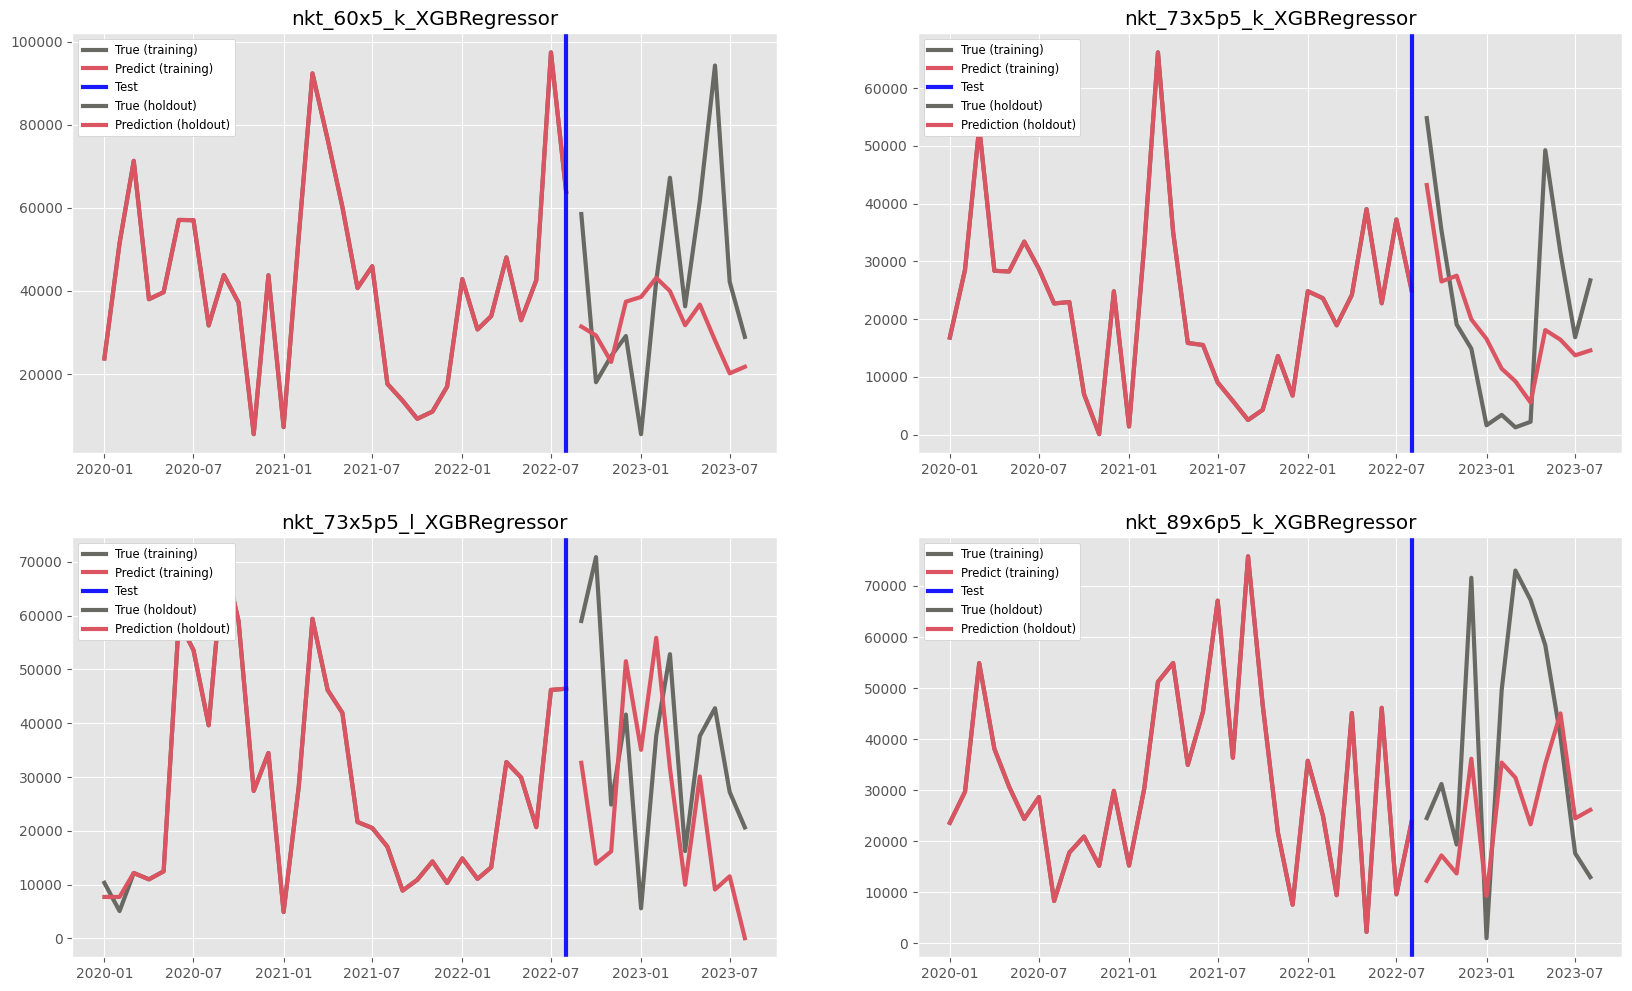

In [167]:
results_plot(y_train_table, y_test_table, 'XGBRegressor', save_fig = True)

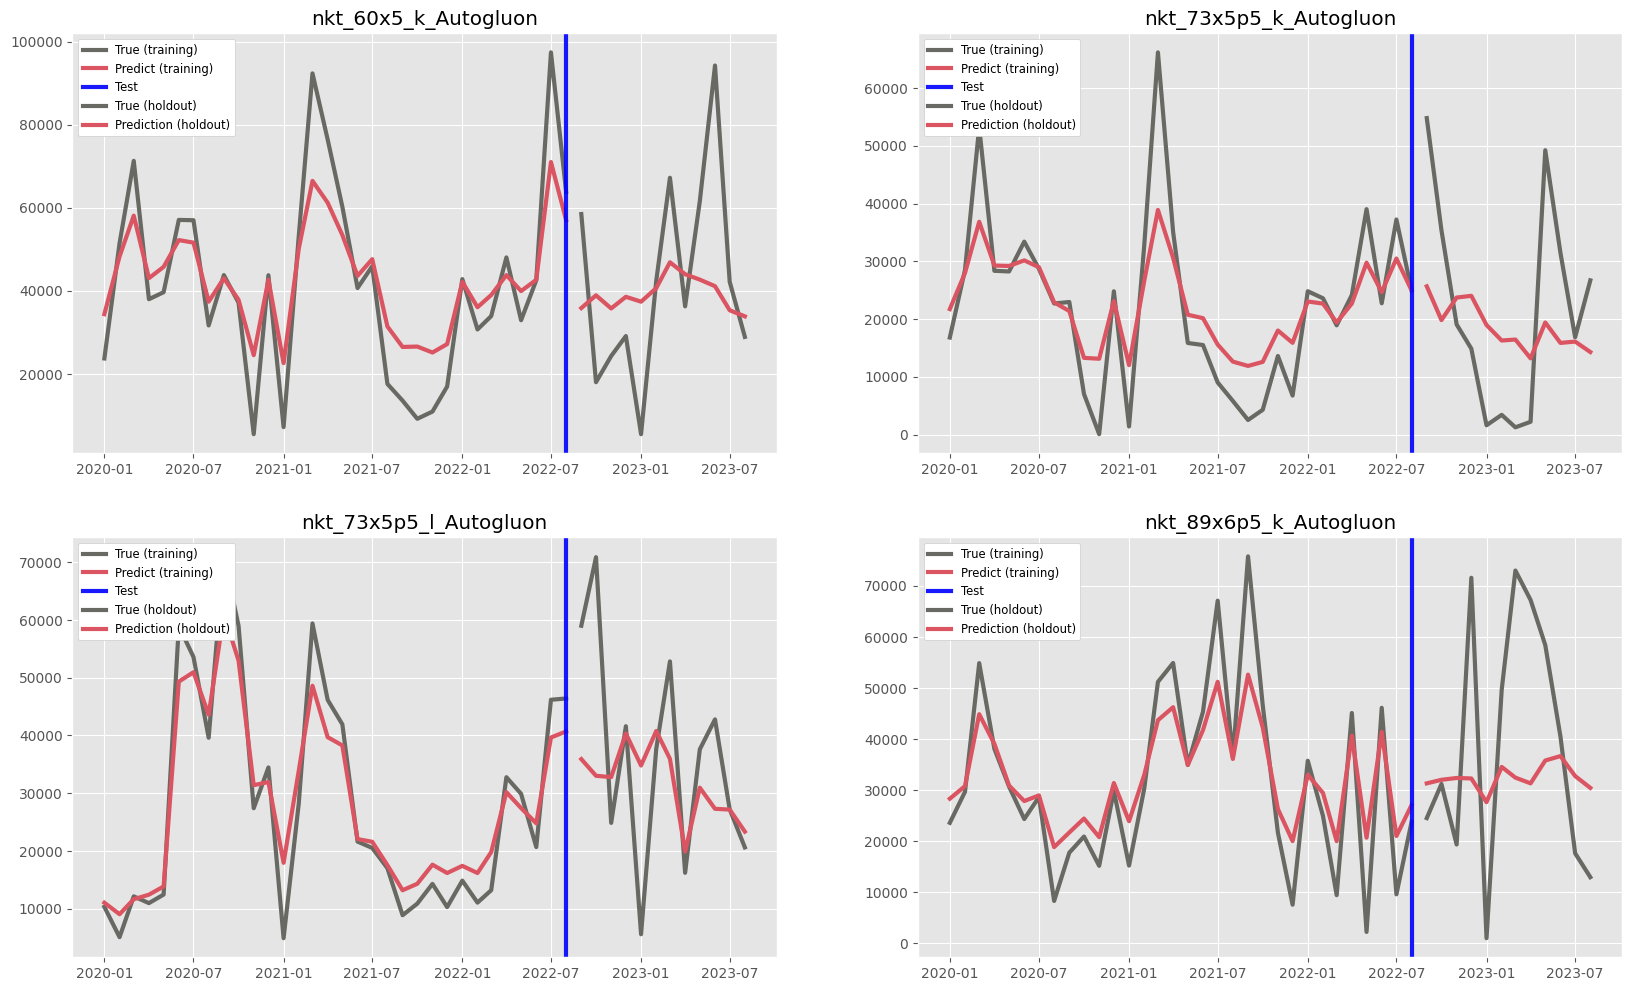

In [168]:
results_plot(y_train_table, y_test_table, 'Autogluon', save_fig = True)

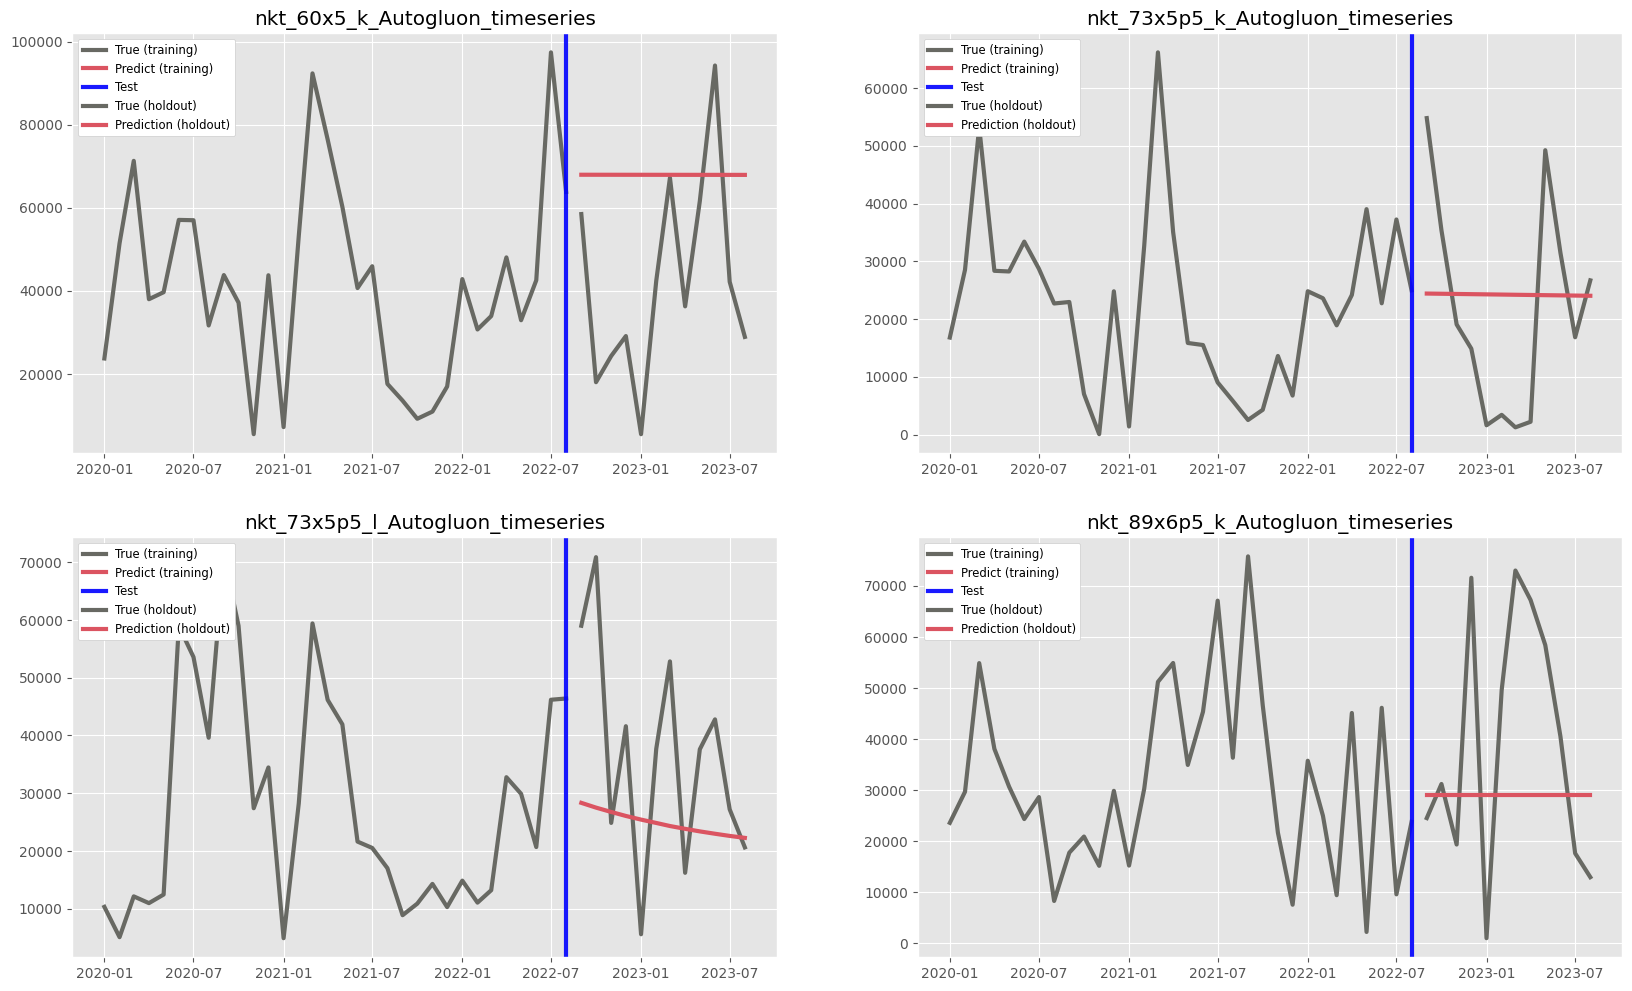

In [169]:
results_plot(y_train_table, y_test_table, 'Autogluon_timeseries', save_fig = True)

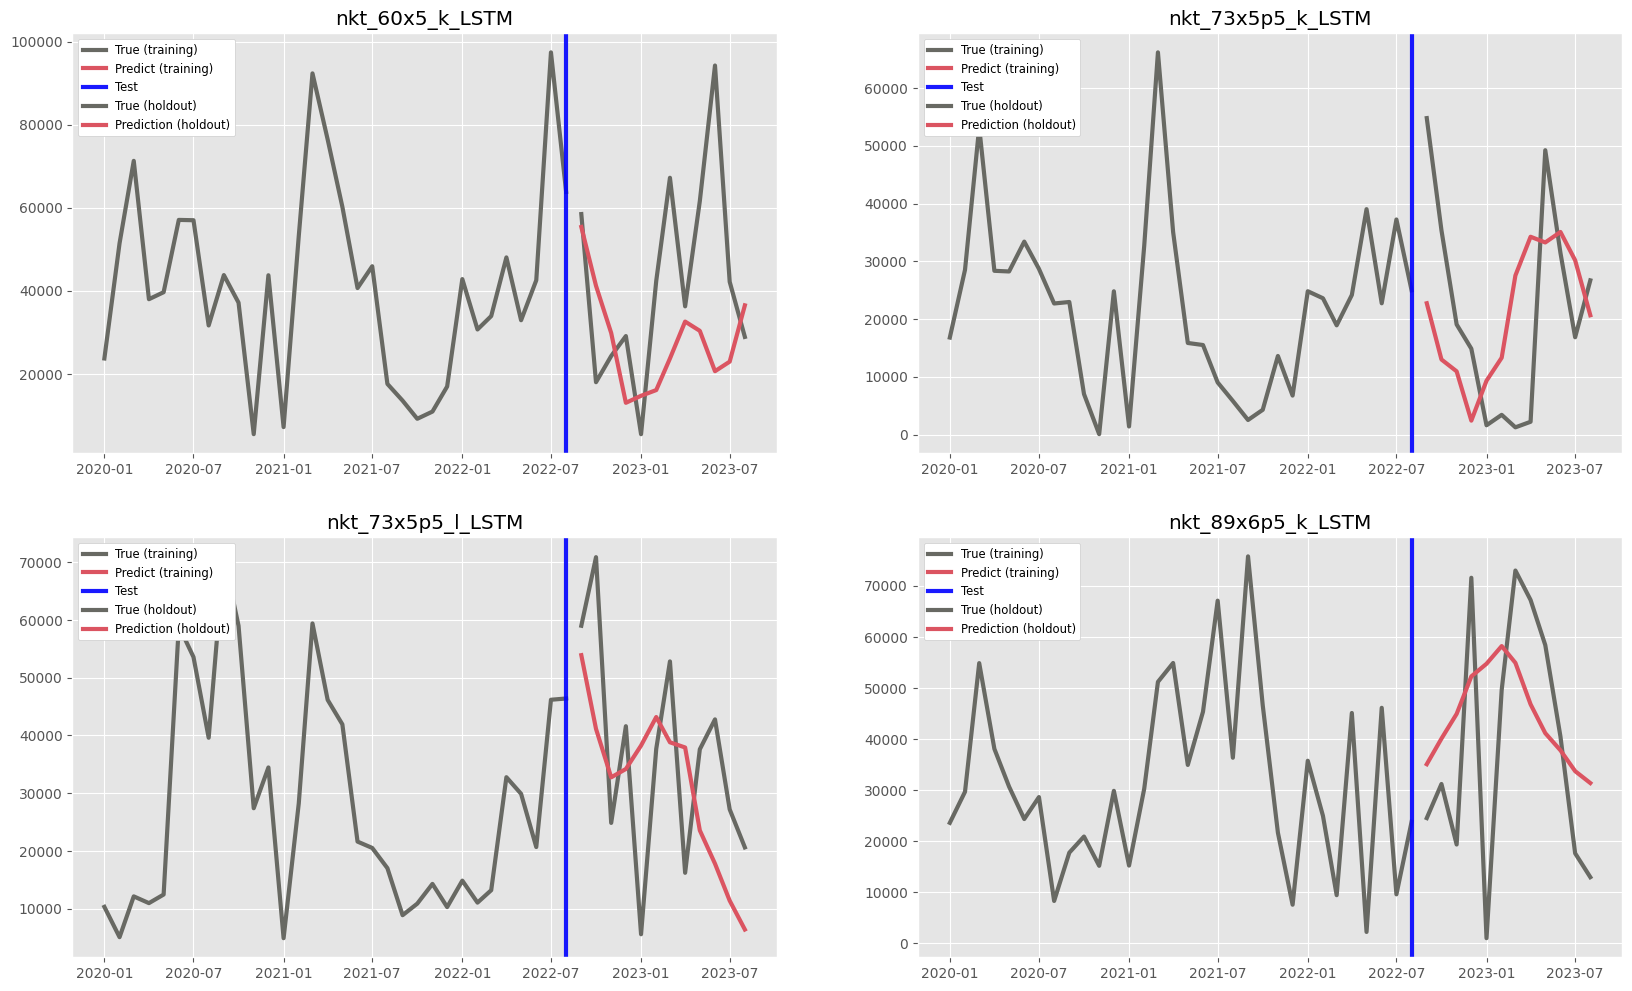

In [170]:
results_plot(y_train_table, y_test_table, 'LSTM', save_fig = True)

#### Расчет метрик

In [128]:
def rmse_table(y_true, y_pred):
    """RMSE ошибка"""

    return ((mean_squared_error(y_true, y_pred))**(1/2)).round(2)

def mape_table(y_true, y_pred):
    """MAPE ошибка"""

    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    mape_accuracy = (1 - mape) * 100
    round_mape_accuracy = round(mape_accuracy, 2)
    return str(round_mape_accuracy) + '%'

In [129]:
def metric_table(y_test_table):
    """Создание таблицы с метриками"""

    # Подготавливаем датасеты
    y_test_table['analog_group_model'] = y_test_table['analog_group'] + '_' + y_test_table['model']
    y_test_table_groupby = y_test_table.groupby(['analog_group','analog_group_model'], as_index=False).agg({'quantity':'sum', 'predict_test':'sum'})

    rmse_dict = {}
    mape_dict = {}
    rmse_sum_dict = {}
    mape_sum_dict = {}

    for sg_model in y_test_table['analog_group_model'].unique():
        y_test_table_sg_model = y_test_table[y_test_table['analog_group_model']==sg_model]

        # Общая сумма потреблений
        quantity_sum = np.array([y_test_table_sg_model['quantity'].sum()])
        predict_sum = np.array([y_test_table_sg_model['predict_test'].sum()])

        # RMSE
        rmse = rmse_table(y_test_table_sg_model['quantity'], y_test_table_sg_model['predict_test'])
        rmse_dict[sg_model] = rmse
        rmse_sum = rmse_table(quantity_sum, predict_sum)
        rmse_sum_dict[sg_model] = rmse_sum

        # MAPE
        mape = mape_table(y_test_table_sg_model['quantity'], y_test_table_sg_model['predict_test'])
        mape_dict[sg_model] = mape
        mape_sum = mape_table(quantity_sum, predict_sum)
        mape_sum_dict[sg_model] = mape_sum

    # Добавление метрик в датасет
    y_test_table_groupby['RMSE'] = round(y_test_table_groupby['analog_group_model'].map(rmse_dict), 2)
    y_test_table_groupby['MAPE_ACCURACY'] = y_test_table_groupby['analog_group_model'].map(mape_dict)
    y_test_table_groupby['RMSE_year'] = round(y_test_table_groupby['analog_group_model'].map(rmse_sum_dict), 2)
    y_test_table_groupby['MAPE_ACCURACY_year'] = y_test_table_groupby['analog_group_model'].map(mape_sum_dict)
    y_test_table_groupby['quantity'] = y_test_table_groupby['quantity'].astype(int)
    y_test_table_groupby['predict_test'] = y_test_table_groupby['predict_test'].astype(int)

    return y_test_table_groupby

In [130]:
df_metric = metric_table(y_test_table)

In [150]:
def display_metric_df(df_metric, analog_group, is_save):
    """Визуализация таблицы с метриками"""

    df_metric_sg = df_metric[df_metric['analog_group']==analog_group]
    df_metric_sg = df_metric_sg.drop(['analog_group'],axis=1).set_index('analog_group_model')

    if is_save == True:
        df_metric_sg.to_excel(f'metrics/df_metric_{analog_group}.xlsx')

    return df_metric_sg

In [151]:
display_metric_df(df_metric, 'nkt_60x5_k', is_save=True)

,quantity,predict_test,RMSE,MAPE_ACCURACY,RMSE_year,MAPE_ACCURACY_year
analog_group_model,,,,,,
nkt_60x5_k_Autogluon,508361,471163,22193.63,17.64%,37198.52,92.68%
nkt_60x5_k_Autogluon_timeseries,508361,815221,34708.67,-76.67%,306859.21,39.64%
nkt_60x5_k_CatBoostRegressor,508361,433883,21031.77,37.64%,74478.57,85.35%
nkt_60x5_k_ElasticNet,508361,464618,19133.48,31.49%,43743.75,91.4%
nkt_60x5_k_LSTM,508361,337334,29341.54,40.27%,171027.77,66.36%
nkt_60x5_k_RandomForestRegressor,508361,468932,21804.80,19.44%,39429.37,92.24%
nkt_60x5_k_XGBRegressor,508361,381072,26326.56,17.97%,127289.12,74.96%


In [152]:
display_metric_df(df_metric, 'nkt_73x5p5_k', is_save=True)

,quantity,predict_test,RMSE,MAPE_ACCURACY,RMSE_year,MAPE_ACCURACY_year
analog_group_model,,,,,,
nkt_73x5p5_k_Autogluon,256861,223835,16593.32,-193.21%,33025.61,87.14%
nkt_73x5p5_k_Autogluon_timeseries,256861,290730,17941.46,-330.02%,33869.22,86.81%
nkt_73x5p5_k_CatBoostRegressor,256861,192511,15651.00,-111.98%,64350.25,74.95%
nkt_73x5p5_k_ElasticNet,256861,225108,12925.82,-133.75%,31753.07,87.64%
nkt_73x5p5_k_LSTM,256861,252728,18503.19,-293.29%,4133.25,98.39%
nkt_73x5p5_k_RandomForestRegressor,256861,227998,14487.89,-143.79%,28863.20,88.76%
nkt_73x5p5_k_XGBRegressor,256861,222746,12992.72,-87.99%,34114.95,86.72%


In [153]:
display_metric_df(df_metric, 'nkt_73x5p5_l', is_save=True)

,quantity,predict_test,RMSE,MAPE_ACCURACY,RMSE_year,MAPE_ACCURACY_year
analog_group_model,,,,,,
nkt_73x5p5_l_Autogluon,436912,382286,17035.74,34.98%,54625.51,87.5%
nkt_73x5p5_l_Autogluon_timeseries,436912,298405,20640.35,36.9%,138506.97,68.3%
nkt_73x5p5_l_CatBoostRegressor,436912,415607,14286.98,41.09%,21304.98,95.12%
nkt_73x5p5_l_ElasticNet,436912,329116,19862.47,34.0%,107795.70,75.33%
nkt_73x5p5_l_LSTM,436912,379399,18403.78,9.81%,57512.79,86.84%
nkt_73x5p5_l_RandomForestRegressor,436912,385074,16411.39,34.62%,51837.75,88.14%
nkt_73x5p5_l_XGBRegressor,436912,297475,25279.20,8.79%,139436.80,68.09%


In [154]:
display_metric_df(df_metric, 'nkt_89x6p5_k', is_save=True)

,quantity,predict_test,RMSE,MAPE_ACCURACY,RMSE_year,MAPE_ACCURACY_year
analog_group_model,,,,,,
nkt_89x6p5_k_Autogluon,467176,389836,23606.46,-161.29%,77340.13,83.45%
nkt_89x6p5_k_Autogluon_timeseries,467176,349221,25651.95,-172.91%,117954.49,74.75%
nkt_89x6p5_k_CatBoostRegressor,467176,416174,19086.84,-173.32%,51001.72,89.08%
nkt_89x6p5_k_ElasticNet,467176,420202,19939.61,-141.68%,46974.14,89.95%
nkt_89x6p5_k_LSTM,467176,531233,22025.80,-380.56%,64057.06,86.29%
nkt_89x6p5_k_RandomForestRegressor,467176,368419,23052.19,-157.96%,98756.63,78.86%
nkt_89x6p5_k_XGBRegressor,467176,310631,22837.73,-9.33%,156545.20,66.49%
